<a href="https://colab.research.google.com/github/deschena/networks_ml_epfl/blob/main/project/exploitation/clustering_city.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install grakel einops torch_geometric node2vec bayesian-optimization optuna

In [1]:
%load_ext autoreload
%autoreload 2

## Colab Setup

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
import sys
sys.path.append("/content/drive/MyDrive/EPFL/Network_ML/Project")  # To import utils

from utils import *
import numpy as np
import networkx as nx
from tqdm import tqdm
import pickle
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
%cd /content/drive/MyDrive/EPFL/Network_ML/Project/exploitation

/content/drive/MyDrive/EPFL/Network_ML/Project/exploitation


In [164]:
from training import *
from models import *
from prepare_data import load_features
from matplotlib import pyplot as plt
import optuna
from optuna.samplers import RandomSampler
import xgboost as xgb

In [165]:
model_type=SimpleGCN

In [36]:
target_city = 'paris'
num_neighbour = 5
device = "cuda"
num_features = 258
all_cities = list_cities()
graph_list = [load_graph(city, transport) for city in tqdm(all_cities) for transport in ["combined"]]
K = compute_graph_kernels(graph_list, n_samples=15)
neighbouring_cities = get_neighbouring_cities(target_city, all_cities, K, num_neighbour)
print(neighbouring_cities)

100%|██████████| 25/25 [00:01<00:00, 15.35it/s]
/Users/xuyixuan/opt/anaconda3/envs/Network_ML/lib/python3.9/site-packages/grakel/graph_kernels.py:495: UserWarning: Kernel List not empty while reaching a base-kernel - the rest kernel names will be ignored
  warnings.warn('Kernel List not empty while reaching a base-kernel - '


['paris', 'grenoble', 'brisbane', 'helsinki', 'prague', 'melbourne']


## Local Setup

In [1]:
import sys
sys.path.append("../")  # To import utils

from utils import *
import numpy as np
import networkx as nx
from tqdm import tqdm
import pickle
np.random.seed(42)

In [2]:
from prepare_data import load_features
from training import *
from models import *
import optuna
from optuna.samplers import RandomSampler

In [3]:
target_city = 'paris'
num_neighbour = 5
device = "cpu"
num_features = 258
all_cities = list_cities()
graph_list = [load_graph(city, transport) for city in tqdm(all_cities) for transport in ["combined"]]
K = compute_graph_kernels(graph_list, n_samples=18)
neighbouring_cities = get_neighbouring_cities(target_city, all_cities, K, num_neighbour)
print(neighbouring_cities)

100%|██████████| 25/25 [00:00<00:00, 49.14it/s]
/Users/xuyixuan/opt/anaconda3/envs/Network_ML/lib/python3.9/site-packages/grakel/graph_kernels.py:495: UserWarning: Kernel List not empty while reaching a base-kernel - the rest kernel names will be ignored
  warnings.warn('Kernel List not empty while reaching a base-kernel - '


['paris', 'winnipeg', 'melbourne', 'luxembourg', 'venice', 'belfast']


## Duration Regression

In [167]:
data = [load_features(city, task="duration_regr") for city in neighbouring_cities]
train_split = data[2:] # Bottom k-1 for training
valid_split = data[1:2] # Top 1 for validating
test_split  = data[:1]

### Bayesian Optimisation

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-5, 1e-3), 'weight_decay': (1e-5, 1e-3), 'hidden_dim': (512, 1028)}


tuner = BayesianOptimization(
    f=lambda lr, weight_decay, hidden_dim: tuning_model(lr, weight_decay, hidden_dim, 
                                                        device=device,
                                                        model_type=model_type,
                                                        num_features=num_features,
                                                        train_split=train_split,
                                                        valid_split=valid_split,
                                                        criterion=torch.nn.MSELoss(),
                                                        regression=True),
    pbounds=pbounds,
    random_state=1,
)

tuner.maximize(
    init_points=5,
    n_iter=20,
)

optimal_params = tuner.max['params']


|   iter    |  target   | hidden... |    lr     | weight... |
-------------------------------------------------------------
| 1         | -0.914    | 727.2     | 0.0007231 | 1.011e-05 |
| 2         | -0.9211   | 668.0     | 0.0001553 | 0.0001014 |
| 3         | -0.8935   | 608.1     | 0.0003521 | 0.0004028 |
| 4         | -0.9159   | 790.0     | 0.000425  | 0.0006884 |
| 5         | -0.933    | 617.5     | 0.0008793 | 3.711e-05 |
| 6         | -0.8989   | 608.3     | 0.0004228 | 0.0002256 |
| 7         | -0.9087   | 607.6     | 0.0008806 | 0.000732  |
| 8         | -0.902    | 609.4     | 0.0002182 | 0.0002315 |
| 9         | -0.8691   | 629.4     | 0.000164  | 0.0009478 |
| 10        | -0.922    | 886.7     | 0.0007313 | 0.0002027 |
| 11        | -0.8957   | 629.7     | 0.0001361 | 0.0002721 |
| 12        | -0.9198   | 1.005e+03 | 0.0006674 | 0.000476  |
| 13        | -0.8836   | 764.2     | 0.0008428 | 0.0009793 |
| 14        | -0.8927   | 629.1     | 0.0005918 | 0.0008127 |
| 15    

### Random Sampling Optimisation

In [168]:
study = optuna.create_study(sampler=RandomSampler(seed=1))
objective = create_objective_pyg(device=device,
                                 model_type=model_type,
                                 num_features=num_features,
                                 train=train_split,
                                 valid=valid_split,
                                 criterion=torch.nn.MSELoss(),
                                 regression=True)
study.optimize(objective, n_trials=25)

[I 2023-06-09 10:55:05,344] A new study created in memory with name: no-name-bc71312e-d7c2-4240-bc07-96d284ab4e1b
[I 2023-06-09 10:55:06,200] Trial 0 finished with value: -0.876021095938521 and parameters: {'lr': 0.0004228517846555483, 'weight_decay': 0.0007231212485077365, 'hidden_dim': 512}. Best is trial 0 with value: -0.876021095938521.
[I 2023-06-09 10:55:07,097] Trial 1 finished with value: -0.8775384729325237 and parameters: {'lr': 0.0003093092469055214, 'weight_decay': 0.0001552883319089419, 'hidden_dim': 559}. Best is trial 1 with value: -0.8775384729325237.
[I 2023-06-09 10:55:08,171] Trial 2 finished with value: -0.8698804471206761 and parameters: {'lr': 0.00019439760926389418, 'weight_decay': 0.0003521051197726173, 'hidden_dim': 717}. Best is trial 1 with value: -0.8775384729325237.
[I 2023-06-09 10:55:09,474] Trial 3 finished with value: -0.8737675979653923 and parameters: {'lr': 0.0005434285666633233, 'weight_decay': 0.00042500256925926186, 'hidden_dim': 866}. Best is tri

In [169]:
optimal_params = study.best_params
print(optimal_params)

{'lr': 0.0006671566987675909, 'weight_decay': 0.0005197402209377255, 'hidden_dim': 1000}


### Our Model

In [170]:
batch_size = 1
num_steps = 1000
eval_every = 100
verbose=False

optimal_hidden_dim = int(optimal_params['hidden_dim'])  # make sure to cast to int because the optimizer works with float
optimal_lr = optimal_params['lr']
optimal_weight_decay = optimal_params['weight_decay']

model = model_type(258, 1, hidden_dim=optimal_hidden_dim)
model = model.to(device)

# Initialize your optimizer with the optimal learning rate and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, weight_decay=optimal_weight_decay)
criterion = torch.nn.MSELoss()

results = pyg_train(
    model, 
    device, 
    train_split+valid_split,
    test_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
    verbose=verbose,
    regression=True
    )


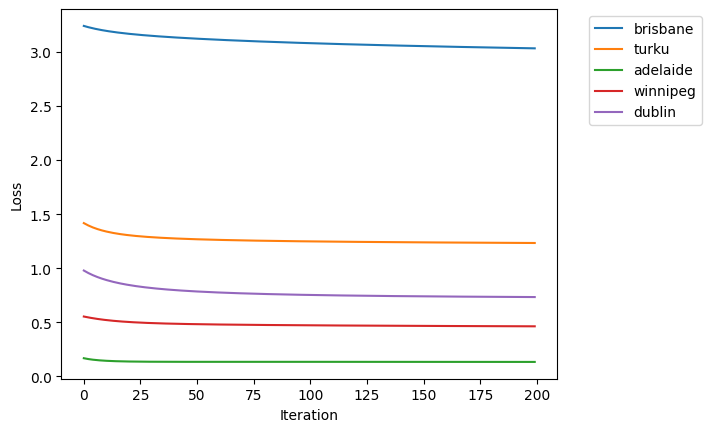

In [171]:
plot_loss(results["loss"], neighbouring_cities, target_city=target_city)

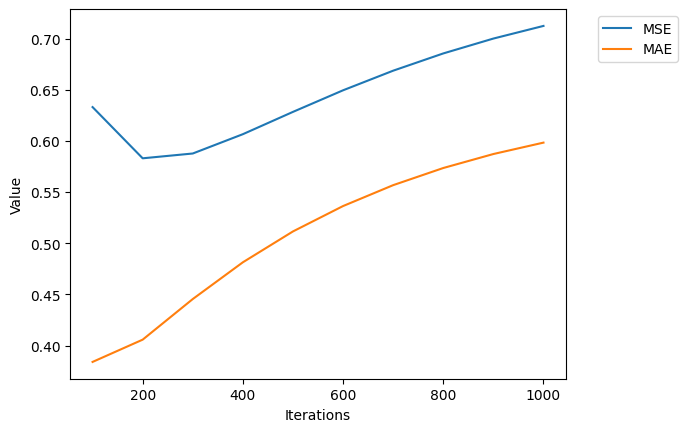

In [172]:
plot_eval(results["eval_metrics"])

In [173]:
results["eval_metrics"]

{'mse': array([0.63313574, 0.58306044, 0.58775753, 0.60664266, 0.62845504,
        0.64956665, 0.66873825, 0.68560195, 0.70014304, 0.71249747]),
 'mae': array([0.38397107, 0.40574721, 0.44545427, 0.48139527, 0.51156473,
        0.53638309, 0.55681145, 0.57356727, 0.58724415, 0.59839672]),
 'x': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])}

### Baseline Model

In [174]:
data = [load_features(city, task="duration_regr") for city in all_cities]

city_index = all_cities.index(target_city)
train_split = data[:city_index] + data[city_index+1:]
valid_split = data[city_index:city_index+1]

In [175]:
model = model_type(258, 1, hidden_dim=optimal_hidden_dim)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, weight_decay=optimal_weight_decay)
criterion = torch.nn.MSELoss()

results = pyg_train(
    model, 
    device, 
    train_split,
    valid_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
    verbose=verbose,
    regression=True
    )

In [176]:
def plot_loss(loss, cities, target_city):
    neighbours = [city for city in cities if city != target_city]
    num_neighbour = len(neighbours)
    for i in range(num_neighbour):
        plt.plot(results["loss"][i::num_neighbour],label=neighbours[i])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

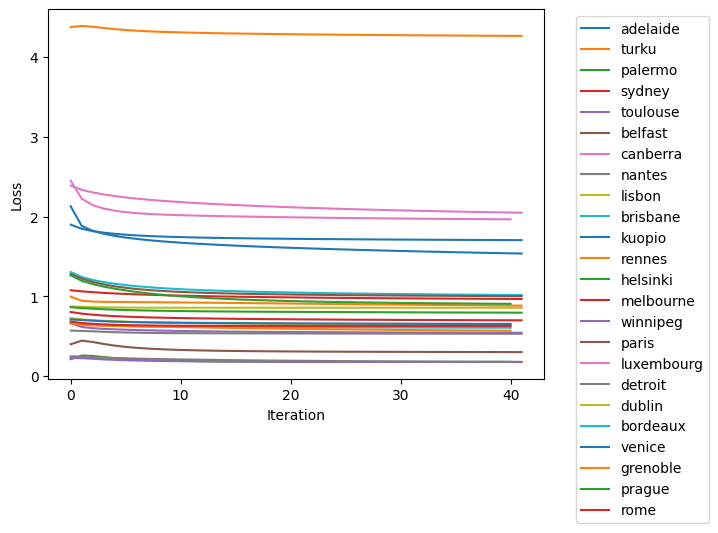

In [177]:
plot_loss(results["loss"], all_cities, target_city=target_city)

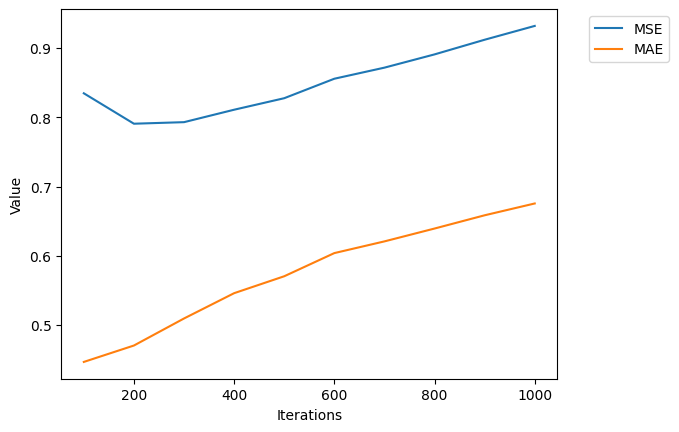

In [178]:
plot_eval(results["eval_metrics"])

In [179]:
results["eval_metrics"]

{'mse': array([0.83463615, 0.7907216 , 0.79296392, 0.8109256 , 0.82754236,
        0.85566139, 0.87166244, 0.89078707, 0.91194737, 0.93189496]),
 'mae': array([0.44685367, 0.47053406, 0.50957435, 0.54608911, 0.57051665,
        0.60395455, 0.62085062, 0.63940293, 0.65852964, 0.67558551]),
 'x': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])}

### Classical ML

#### Classical ML on neighbours

In [4]:
data = [load_features(city, task="duration_regr", format="numpy") for city in neighbouring_cities]
train_split = data[2:] # Bottom k-1 for training
valid_split = data[1:2] # Top 1 for validating
test_split  = data[:1]

In [5]:
objective = create_objective_sklearn(train_split, valid_split, "sum")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

[I 2023-06-09 15:13:16,533] A new study created in memory with name: no-name-d5e03cbd-62e5-4c6a-801f-e9ad4b0fad19
[I 2023-06-09 15:13:22,326] Trial 0 finished with value: 0.39340803027153015 and parameters: {'learning_rate': 0.3506996303496444, 'max_depth': 2, 'n_estimators': 457, 'subsample': 0.8953156622720301, 'colsample_bytree': 0.24255761213869992, 'reg_lambda': 0.24478719370426225, 'reg_alpha': 0.00020866428331357478}. Best is trial 0 with value: 0.39340803027153015.
[I 2023-06-09 15:13:34,755] Trial 1 finished with value: 2.367091655731201 and parameters: {'learning_rate': 0.31654648611906977, 'max_depth': 3, 'n_estimators': 905, 'subsample': 0.16123984373156683, 'colsample_bytree': 0.5423601011376068, 'reg_lambda': 0.00683964511457193, 'reg_alpha': 0.0005374805510857194}. Best is trial 0 with value: 0.39340803027153015.
[I 2023-06-09 15:13:42,584] Trial 2 finished with value: 2.1994104385375977 and parameters: {'learning_rate': 0.4094406585658492, 'max_depth': 8, 'n_estimators'

In [6]:
study.best_params

{'learning_rate': 0.03289591615751874,
 'max_depth': 5,
 'n_estimators': 101,
 'subsample': 0.6134658085638366,
 'colsample_bytree': 0.8710980046994373,
 'reg_lambda': 0.0009661767793072918,
 'reg_alpha': 0.1295607072162709}

In [7]:
model = xgb.XGBRegressor(**study.best_params)

results = sklearn_train(
    model,
    train_split+valid_split,
    test_split,
    edge_aggr="sum"
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [8]:
study.best_params

{'learning_rate': 0.03289591615751874,
 'max_depth': 5,
 'n_estimators': 101,
 'subsample': 0.6134658085638366,
 'colsample_bytree': 0.8710980046994373,
 'reg_lambda': 0.0009661767793072918,
 'reg_alpha': 0.1295607072162709}

In [9]:
results["train_metrics"]["mse"], results["valid_metrics"]["mse"]

(0.42596823, 1.2396884)

In [10]:
results["train_metrics"]

{'mse': 0.42596823, 'mae': 0.35389355}

In [11]:
results["train_metrics"]["mae"], results["valid_metrics"]["mae"]

(0.35389355, 0.5666077)

#### Classical ML on all data exclude target city

In [12]:
data = [load_features(city, task="duration_regr") for city in all_cities]

city_index = all_cities.index(target_city)
train_split = data[:city_index] + data[city_index+1:]
valid_split = data[city_index:city_index+1]

In [13]:
# objective = create_objective_sklearn(train_split, valid_split, "sum")
# study = optuna.create_study(direction='minimize', sampler=RandomSampler(seed=42))
# study.optimize(objective, n_trials=40)

In [14]:
model = xgb.XGBRegressor(**study.best_params)

results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum"
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [15]:
results["train_metrics"]["mse"], results["valid_metrics"]["mse"]

(0.65396, 1.162746)

In [16]:
results["train_metrics"]["mae"], results["valid_metrics"]["mae"]

(0.3954291, 0.53466445)

## Link Prediction

### Our Model

In [ ]:
data = [load_features(city, task="link_pred", neg_sample_ratio=20) for city in neighbouring_cities]
train_split = data[2:] # Bottom k-1 for training
valid_split = data[1:2] # Top 1 for validating
test_split  = data[:1]

In [ ]:
study = optuna.create_study(sampler=RandomSampler(seed=1))
objective = create_objective_pyg(device=device,
                                 model_type=model_type,
                                 num_features=num_features,
                                 train=train_split,
                                 valid=valid_split,
                                 criterion=torch.nn.BCEWithLogitsLoss(),
                                 regression=False)
study.optimize(objective, n_trials=2)

[I 2023-06-09 08:18:03,095] A new study created in memory with name: no-name-d6372162-be72-418f-a108-0f5f67df303c
[I 2023-06-09 08:54:43,873] Trial 0 finished with value: 0.0 and parameters: {'lr': 0.0004228517846555483, 'weight_decay': 0.0007231212485077365, 'hidden_dim': 512}. Best is trial 0 with value: 0.0.
[I 2023-06-09 09:40:18,233] Trial 1 finished with value: 0.0 and parameters: {'lr': 0.0003093092469055214, 'weight_decay': 0.0001552883319089419, 'hidden_dim': 559}. Best is trial 0 with value: 0.0.


In [ ]:
num_features = 258
batch_size = 1
num_steps = 1000
eval_every = 100
verbose=False
optimal_params = study.best_params

optimal_hidden_dim = int(optimal_params['hidden_dim'])  # make sure to cast to int because the optimizer works with float
optimal_lr = optimal_params['lr']
optimal_weight_decay = optimal_params['weight_decay']

model = model_type(num_features, 1, hidden_dim=optimal_hidden_dim)
model = model.to(device)

# Initialize your optimizer with the optimal learning rate and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, weight_decay=optimal_weight_decay)
criterion=torch.nn.BCEWithLogitsLoss()

results = pyg_train(
    model, 
    device, 
    train_split+valid_split,
    test_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
    verbose=verbose,
    regression=False
    )

KeyboardInterrupt: 

In [ ]:
plot_eval(results['eval_metrics'], regression=False)

In [ ]:
plot_loss(results['loss'], cities=neighbouring_cities, target_city=target_city)

### Baseline Model

In [ ]:
data = [load_features(city, task="link_pred", neg_sample_ratio=20) for city in all_cities]

city_index = all_cities.index(target_city)
train_split = data[:city_index] + data[city_index+1:]
valid_split = data[city_index:city_index+1]

In [ ]:
model = model_type(258, 1, hidden_dim=optimal_hidden_dim)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, weight_decay=optimal_weight_decay)
criterion = torch.nn.MSELoss()

results = pyg_train(
    model, 
    device, 
    train_split,
    valid_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
    verbose=verbose,
    regression=False
    )

In [ ]:
plot_eval(results['eval_metrics'], regression=False)

In [ ]:
plot_loss(results['loss'], cities=all_cities, target_city=target_city)

### Classic ML

#### Classical ML on neighbours

In [37]:
data = [load_features(city, task="link_pred", neg_sample_ratio=10) for city in neighbouring_cities]
train_split = data[2:] # Bottom k-1 for training
valid_split = data[1:2] # Top 1 for validating
test_split  = data[:1]

In [38]:
objective = create_objective_sklearn(train_split, valid_split, "sum", regression=False)
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective, n_trials=8)

[I 2023-06-09 17:26:25,435] A new study created in memory with name: no-name-229baec2-a093-47be-a86c-a29a3119e73b


Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:36:06,094] Trial 0 finished with value: 0.19443087445041524 and parameters: {'learning_rate': 0.05611516415334506, 'max_depth': 9, 'n_estimators': 759, 'subsample': 0.6387926357773329, 'colsample_bytree': 0.24041677639819287, 'reg_lambda': 0.0004207053950287938, 'reg_alpha': 0.0001707396743152812}. Best is trial 0 with value: 0.19443087445041524.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:42:38,618] Trial 1 finished with value: 0.1856594110115237 and parameters: {'learning_rate': 0.5399484409787431, 'max_depth': 6, 'n_estimators': 737, 'subsample': 0.1185260448662222, 'colsample_bytree': 0.9729188669457949, 'reg_lambda': 0.21368329072358744, 'reg_alpha': 0.0007068974950624604}. Best is trial 0 with value: 0.19443087445041524.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:44:21,691] Trial 2 finished with value: 0.17607003891050585 and parameters: {'learning_rate': 0.02310201887845294, 'max_depth': 2, 'n_estimators': 374, 'subsample': 0.5722807884690141, 'colsample_bytree': 0.48875051677790415, 'reg_lambda': 0.0014618962793704966, 'reg_alpha': 0.0280163515871626}. Best is trial 0 with value: 0.19443087445041524.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:48:29,313] Trial 3 finished with value: 0.18611987381703468 and parameters: {'learning_rate': 0.01901024531987036, 'max_depth': 3, 'n_estimators': 430, 'subsample': 0.5104629857953323, 'colsample_bytree': 0.8066583652537123, 'reg_lambda': 0.0006290644294586153, 'reg_alpha': 0.011400863701127324}. Best is trial 0 with value: 0.19443087445041524.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:49:17,772] Trial 4 finished with value: 0.19992690058479531 and parameters: {'learning_rate': 0.15304852121831464, 'max_depth': 1, 'n_estimators': 647, 'subsample': 0.2534717113185624, 'colsample_bytree': 0.1585464336867516, 'reg_lambda': 0.6245139574743068, 'reg_alpha': 0.7286653737491037}. Best is trial 4 with value: 0.19992690058479531.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:50:42,549] Trial 5 finished with value: 0.21444114737883282 and parameters: {'learning_rate': 0.4138040112561014, 'max_depth': 3, 'n_estimators': 188, 'subsample': 0.7158097238609412, 'colsample_bytree': 0.4961372443656412, 'reg_lambda': 0.00030771802712506853, 'reg_alpha': 0.009565499215943823}. Best is trial 5 with value: 0.21444114737883282.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 17:56:49,688] Trial 6 finished with value: 0.10582639714625447 and parameters: {'learning_rate': 0.011715937392307063, 'max_depth': 9, 'n_estimators': 333, 'subsample': 0.6962700559185838, 'colsample_bytree': 0.3805399684804699, 'reg_lambda': 0.012030178871154668, 'reg_alpha': 0.015375920235481757}. Best is trial 5 with value: 0.21444114737883282.


Model evaluated
Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...


[I 2023-06-09 18:31:55,541] Trial 7 finished with value: 0.15517241379310343 and parameters: {'learning_rate': 0.02342658105820405, 'max_depth': 9, 'n_estimators': 798, 'subsample': 0.9455490474077702, 'colsample_bytree': 0.905344615384884, 'reg_lambda': 0.024637685958997457, 'reg_alpha': 0.48696409415208936}. Best is trial 5 with value: 0.21444114737883282.


Model evaluated


In [39]:
model = xgb.XGBClassifier(**study.best_params)

results = sklearn_train(
    model,
    train_split+valid_split,
    test_split,
    edge_aggr="sum",
    normalize_targets=False,  # Very important for link prediction
    train_criterions=["accuracy", "f1"],
    valid_criterions=["accuracy", "f1"],
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [40]:
results["train_metrics"]["f1"], results["valid_metrics"]["f1"]

(0.7238241258222464, 0.13444580111246776)

In [41]:
results["train_metrics"]["accuracy"], results["valid_metrics"]["accuracy"]

(0.9565751613655805, 0.9079657251666138)

#### Classical ML on all data exclude target city

In [42]:
data = [load_features(city, task="link_pred", neg_sample_ratio=10) for city in all_cities]

city_index = all_cities.index(target_city)
train_split = data[:city_index] + data[city_index+1:]
valid_split = data[city_index:city_index+1]

In [43]:
# objective = create_objective_sklearn(train_split, valid_split, "sum", regression=False)
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

In [44]:
model = xgb.XGBClassifier(**study.best_params)

results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum",
    normalize_targets=False,  # Very important for link prediction
    train_criterions=["accuracy", "f1"],
    valid_criterions=["accuracy", "f1"],
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [45]:
results["train_metrics"]["f1"], results["valid_metrics"]["f1"]

(0.4443514410870233, 0.15486961149547632)

In [46]:
results["train_metrics"]["accuracy"], results["valid_metrics"]["accuracy"]

(0.9308964835222032, 0.9083696373445659)